In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import os.path as osp
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.nn.functional import one_hot 
from datetime import datetime

import tensorflow as tf
from tensorflow.keras import losses
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import load_model


from src.models.classifiers import CNNtf
import src.cf_methods.countergan.utils  as cutils

tf.experimental.numpy.experimental_enable_numpy_behavior()

plt.style.use('seaborn-v0_8-darkgrid')

In [2]:
from src.utils import seed_tf

seed_tf()

Loading MNIST data

In [3]:
def convert_multiclass_to_binary(x, y, initial_class, target_class, class_encoding):
    init_class_ind = tf.where(y==initial_class)
    target_class_ind = tf.where(y==target_class)

    y_bin = tf.concat([y[init_class_ind], y[target_class_ind]], axis=0)
    x_bin = tf.concat([x[init_class_ind], x[target_class_ind]], axis=0)

    y_bin_encoded = tf.where(y_bin==initial_class, 
                             class_encoding[initial_class], 
                             class_encoding[target_class])

    return x_bin, y_bin_encoded 

In [4]:
INIT_CLASS = 0
DESIRED_CLASS = 4  # This is the target class that the generator will learn to synthetize
N_CLASSES = 2

class_encodings = {INIT_CLASS: 0, DESIRED_CLASS: 1}
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = (x_train / 255.).astype("float32")
x_test = (x_test / 255.).astype("float32")

In [5]:
X_train, y_train = convert_multiclass_to_binary(x_train, y_train, INIT_CLASS, DESIRED_CLASS, class_encodings) 
X_test, y_test = convert_multiclass_to_binary(x_test, y_test, INIT_CLASS, DESIRED_CLASS, class_encodings)

X_train = tf.transpose(X_train, perm=(0, 2, 3, 1))
X_test = tf.transpose(X_test, perm=(0, 2, 3, 1))

y_train_encoded = to_categorical(y_train, N_CLASSES)
y_test__encoded = to_categorical(y_test, N_CLASSES)

## Train a classifier and AE

In [ ]:
"""import tensorflow as tf
from tensorflow import keras
import tensorflow.keras as tfk
import tensorflow.keras.layers as tl
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential

class CNNtf(Model):
    def __init__(self, input_channels, num_classes):
        super(CNNtf, self).__init__()

        self.input_channels = input_channels
        self.num_classes = num_classes

        # First conv block
        self.main = [
            tl.Conv2D(8, kernel_size=7, strides=1, padding="same", input_shape=(None, None, input_channels)),
            tl.ReLU(),
            tl.MaxPool2D(pool_size=2, strides=2),
            # tl.Dropout(0.1),
            # Second conv block
            tl.Conv2D(16, kernel_size=5, strides=1, padding="same"),
            tl.ReLU(),
            tl.MaxPool2D(pool_size=2, strides=2),
            # tl.Dropout(0.1),
            # Third conv block
            tl.Conv2D(32, kernel_size=3, strides=1, padding="same"),
            tl.ReLU(),
            tl.MaxPool2D(pool_size=2, strides=2),
            # tl.Dropout(0.1),
            tl.Flatten(),
        ]

        # Classifier layer
        self.classifier = [tl.Dense(128), tl.Dense(num_classes)]

    def call(self, x):
        # Forward pass through conv layers
        for layer in self.main:
            x = layer(x)
            # print(x.shape)

        # Classification layer
        x = self.classifier[0](x)
        logits = self.classifier[1](x)

        return logits 

    def get_params_num(self):
        total_params = 0

        # Count trainable parameters in main layers
        for layer in self.main:
            total_params += np.sum(
                [tfk.backend.count_params(w) for w in layer.trainable_weights]
            )

        # Count trainable parameters in classifier
        for layer in self.classifier:
            total_params += np.sum(
                [tfk.backend.count_params(w) for w in layer.trainable_weights]
            )
        # total_params += np.sum(
        #     [tfk.backend.count_params(w) for w in self.classifier.trainable_weights]
        # )

        return total_params"""

In [7]:
batch_size = 64
h, w, ch = X_train.shape[1:]
input_shape = (None, h, w, ch) # for tf models, it goes batch_size x height x width x channels

# saved_model_dir = r'D:\PycharmProjects\RecourseRobustnessBenchmark\carla_visual\models\weights\tf'
# fname_template = f'classifier_{ds_name.lower()}'
# ext = 'keras'
# file_name = f'{fname_template}_{FIRST_CLASS}_{SECOND_CLASS}.{ext}' if is_binary_clf else f'{fname_template}.{ext}'


In [26]:
classifier = CNNtf(input_channels=ch, num_classes=N_CLASSES)
classifier.build(input_shape)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#loss = 'binary_crossentropy' if is_binary_clf else 'categorical_crossentropy'
print('Number of trainable parameters in the model: ', classifier.get_params_num())

Number of trainable parameters in the model:  45506.0


In [27]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=0,
    patience=3,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)
num_epochs = 15

classifier.compile(optimizer="adam", 
                   loss=loss,
                   metrics=['accuracy'])
classifier.fit(X_train, y_train, batch_size=batch_size, shuffle=True, epochs=num_epochs, 
               validation_split=0.2, callbacks=[early_stopping_callback])

Epoch 1/15
150/150 [==============================] - 4s 18ms/step - loss: 0.1496 - accuracy: 0.9440 - val_loss: 0.0252 - val_accuracy: 0.9954
Epoch 2/15
150/150 [==============================] - 3s 17ms/step - loss: 0.0526 - accuracy: 0.9832 - val_loss: 0.0318 - val_accuracy: 0.9896
Epoch 3/15
150/150 [==============================] - 2s 17ms/step - loss: 0.0428 - accuracy: 0.9869 - val_loss: 0.0435 - val_accuracy: 0.9846
Epoch 4/15
150/150 [==============================] - 2s 16ms/step - loss: 0.0368 - accuracy: 0.9887 - val_loss: 0.0473 - val_accuracy: 0.9854


In [28]:
pred_logits = classifier.predict(X_test)
pred_targets = tf.argmax(pred_logits, axis=1, output_type=tf.int32)

acc = tf.keras.metrics.Accuracy()
acc.update_state(pred_targets, y_test)
baseline_accuracy = acc.result().numpy()
print("Model's accuracy: {:5.2f}%".format(100 * baseline_accuracy))

63/63 [==============================] - 0s 5ms/step
Model's accuracy: 98.70%


In [29]:
saved_model_dir = r'D:\PycharmProjects\CF-Robustness-Benchmark\notebooks\experiments\fmnist_classification\binary\tf_checkpoints'
file_name = f'classifier_{INIT_CLASS}_{DESIRED_CLASS}.keras'
classifier.save(osp.join(saved_model_dir, file_name))

Train an AE 

In [32]:
from src.cf_methods.countergan import create_convolutional_autoencoder
from src.cf_methods.countergan import utils as cutils
from pprint import pprint

In [ ]:
def add_noise(x, noise_factor=0.5):
    noise_factor = 0.5
    x_noisy = x + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x.shape)
    x_noisy = np.clip(x_noisy, 0., 1.)
    return x_noisy

autoencoder = create_convolutional_autoencoder(in_shape=(28, 28, 1))
training = autoencoder.fit(
    add_noise(X_train), X_train, epochs=5, batch_size=32, shuffle=True,
    verbose=0, validation_data=(X_test, X_test)
)
print(f"Training loss: {training.history['loss'][-1]:.4f}")
print(f"Validation loss: {training.history['val_loss'][-1]:.4f}")

# Compute the reconstruction error of noise data
samples = np.random.uniform(low=0.0, high=1.0, size=(1000, 28, 28, 1))
reconstruction_error_noise = cutils.compute_reconstruction_error(samples, autoencoder)

# Save and print the autoencoder metrics
reconstruction_error = cutils.compute_reconstruction_error(X_test, autoencoder)
autoencoder_metrics = {
    "reconstruction_error": cutils.format_metric(reconstruction_error),
    "reconstruction_error_noise": cutils.format_metric(reconstruction_error_noise),
}

pprint(autoencoder_metrics)


Training loss: 0.0162
Validation loss: 0.0133
63/63 [==============================] - 1s 16ms/step
{'reconstruction_error': '3.148 ± 0.032',
 'reconstruction_error_noise': '8.907 ± 0.010'}


In [37]:
autoencoder.save(r"D:\PycharmProjects\CF-Robustness-Benchmark\notebooks\experiments\fmnist_ae\binary_fmnist_autoencoder.h5")

## Load classifier

In [6]:
# weights_dir = r'D:\PycharmProjects\Counterfactual-Robustness-Benchmark\src\models\weights'
saved_model_dir = r'D:\PycharmProjects\CF-Robustness-Benchmark\notebooks\experiments\fmnist_classification\binary\tf_checkpoints'
file_name = f'classifier_{INIT_CLASS}_{DESIRED_CLASS}.keras'

baseline_classifier = load_model(osp.join(saved_model_dir, file_name), 
                        custom_objects={'CNNtf': CNNtf})

y_prob = baseline_classifier.predict(X_test)

accuracy = (y_prob.argmax(axis=1) == y_test[:, 0]).numpy().mean()
print(f"Classifier accuracy test: {accuracy:.3%}")

63/63 [==============================] - 0s 4ms/step
Classifier accuracy test: 98.700%


Load AE

In [7]:
weights_dir = r'D:\PycharmProjects\CF-Robustness-Benchmark\notebooks\experiments\fmnist_ae'
autoencoder = load_model(osp.join(weights_dir, "binary_fmnist_autoencoder.h5"),
                             custom_objects={'mse': losses.mse})
reconstruction_error_test = cutils.compute_reconstruction_error(X_test, autoencoder)
print(f"AE average reconstruction error: {reconstruction_error_test.mean():.3f}")

AE average reconstruction error: 3.148


# Training of CounterGAN

In [8]:
from src.cf_methods.countergan import create_generator, create_discriminator, define_countergan

In [9]:
generator = create_generator(in_shape=(28, 28, 1))
discriminator = create_discriminator(in_shape=(28, 28, 1))

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), name='reshape_1/Reshape:0', description="created by layer 'reshape_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), name='Placeholder:0', description="created by layer 'activity_regularization'")


In [12]:
def train_countergan(n_discriminator_steps, n_generator_steps, n_training_iterations,
                     classifier, discriminator, generator, batches,
                     weighted_version=False, negative_batches=None, positive_batches=None,
                     ):
    """ Main function: train the CounteRGAN"""

    def check_divergence(x_generated):
        return np.all(np.isnan(x_generated))

    def print_training_information(generator, classifier, X_test, iteration):
        X_gen = generator.predict(X_test)
        clf_pred_test = classifier.predict(X_test) # y_M 
        clf_pred = classifier.predict(X_gen)  # y_cf

        delta_clf_pred = (clf_pred - clf_pred_test)[:, class_encodings[DESIRED_CLASS]]
        y_target = to_categorical([class_encodings[DESIRED_CLASS]] * len(clf_pred), num_classes=N_CLASSES)
        print('='*88)
        print(f"Training iteration {iteration} at {datetime.now()}")

        # Plot original images, residuals, and generated images
        sample_indices  = np.random.choice(len(X_test), 10, replace=False)
        residuals = X_gen[sample_indices]-X_test[sample_indices]

        save_dir = r'D:\PycharmProjects\CF-Robustness-Benchmark\cf_output\fmnist\countergan_binary\visualizations'
        cutils.plot_generated_images(X_test[sample_indices], n_plots=10, n_plots_per_row=10, save_path=osp.join(save_dir, f'original_images_iter_{iteration}.png'))
        cutils.plot_generated_images(residuals, n_plots=10, n_plots_per_row=10, residuals=True, save_path=osp.join(save_dir, f'residuals_iter_{iteration}.png'))
        cutils.plot_generated_images(X_gen[sample_indices], n_plots=10, n_plots_per_row=10, save_path=osp.join(save_dir, f'generated_images_iter_{iteration}.png'))

        reconstruction_error = np.mean(cutils.compute_reconstruction_error(X_gen, autoencoder))
        print(f"Autoencoder reconstruction error (infinity to 0): {reconstruction_error:.3f}")
        print(f"Counterfactual prediction gain (0 to 1): {delta_clf_pred.mean():.3f}")
        print(f"Sparsity (L1, infinity to 0): {np.mean(np.abs(X_gen-X_test)):.3f}")


    countergan = define_countergan(generator, discriminator, classifier)

    for iteration in tqdm(range(n_training_iterations)):
        # Periodically print and plot training information
        if (iteration % 100 == 0) or (iteration == n_training_iterations - 1):
            print_training_information(generator, classifier, X_test, iteration)

        # Train the discriminator
        discriminator.trainable = True
        for _ in range(n_discriminator_steps):
            x_fake_input, _ = next(batches)
            x_real = x_fake_input

            x_fake = cutils.generate_fake_samples(x_fake_input, generator)

            x_batch = np.concatenate([x_real, x_fake])
            y_batch = np.concatenate([np.ones(len(x_real)), np.zeros(len(x_fake))])

            # Shuffle real and fake examples
            p = np.random.permutation(len(y_batch))
            x_batch, y_batch = x_batch[p], y_batch[p]
            discriminator.train_on_batch(x_batch, y_batch)

        # Train the generator
        discriminator.trainable = False
        for _ in range(n_generator_steps):
            x_fake_input, _ = next(batches)
            y_fake = np.ones(len(x_fake_input))
            y_target = to_categorical([class_encodings[DESIRED_CLASS]] * len(x_fake_input),
                                          num_classes=N_CLASSES)
            
            #print(x_fake_input.shape, x_fake_input.dtype)
            #print(y_fake.shape, y_target.shape)
            countergan.train_on_batch(x_fake_input, [y_fake, y_target])
    
    return countergan

In [13]:
batches = cutils.infinite_data_stream(X_train, y_train, batch_size=128)

  0%|          | 0/10000 [00:00<?, ?it/s]

63/63 [==============================] - 0s 5ms/step
Training iteration 0 at 2025-05-30 16:44:33.216863


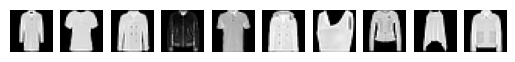

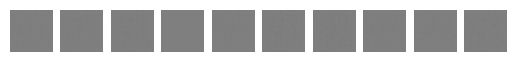

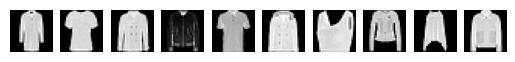

Autoencoder reconstruction error (infinity to 0): 3.156
Counterfactual prediction gain (0 to 1): -0.001
Sparsity (L1, infinity to 0): 0.007


  1%|          | 100/10000 [03:06<5:26:59,  1.98s/it]

63/63 [==============================] - 0s 6ms/step
Training iteration 100 at 2025-05-30 16:47:39.797461


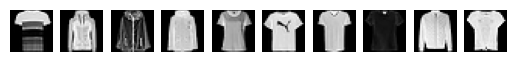

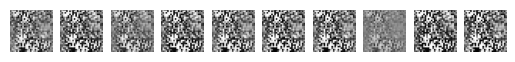

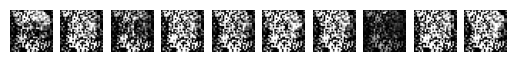

Autoencoder reconstruction error (infinity to 0): 15.911
Counterfactual prediction gain (0 to 1): 0.504
Sparsity (L1, infinity to 0): 0.489


  2%|▏         | 200/10000 [06:31<5:47:12,  2.13s/it]

63/63 [==============================] - 0s 5ms/step
Training iteration 200 at 2025-05-30 16:51:05.007343


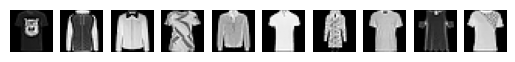

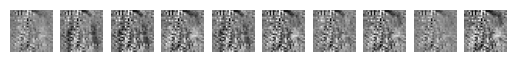

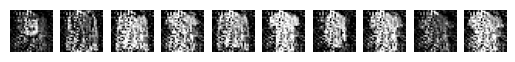

Autoencoder reconstruction error (infinity to 0): 10.005
Counterfactual prediction gain (0 to 1): 0.504
Sparsity (L1, infinity to 0): 0.261


  3%|▎         | 300/10000 [10:03<5:24:12,  2.01s/it]

63/63 [==============================] - 0s 5ms/step
Training iteration 300 at 2025-05-30 16:54:37.114820


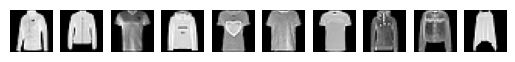

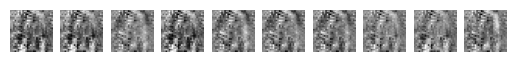

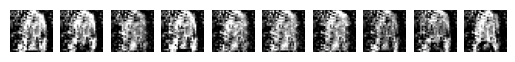

Autoencoder reconstruction error (infinity to 0): 8.756
Counterfactual prediction gain (0 to 1): 0.502
Sparsity (L1, infinity to 0): 0.266


  4%|▍         | 400/10000 [13:38<5:19:56,  2.00s/it]

63/63 [==============================] - 0s 6ms/step
Training iteration 400 at 2025-05-30 16:58:12.114865


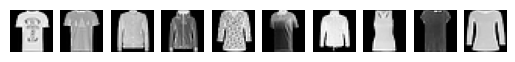

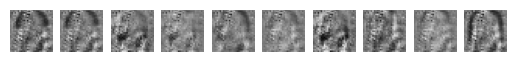

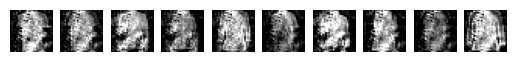

Autoencoder reconstruction error (infinity to 0): 6.443
Counterfactual prediction gain (0 to 1): 0.500
Sparsity (L1, infinity to 0): 0.193


  5%|▌         | 500/10000 [17:07<5:24:36,  2.05s/it]

63/63 [==============================] - 0s 5ms/step
Training iteration 500 at 2025-05-30 17:01:41.214912


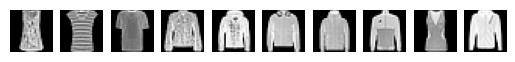

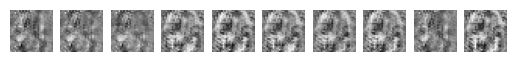

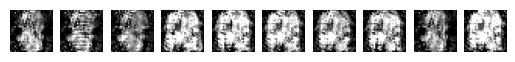

Autoencoder reconstruction error (infinity to 0): 7.416
Counterfactual prediction gain (0 to 1): 0.504
Sparsity (L1, infinity to 0): 0.224


  6%|▌         | 600/10000 [20:35<5:04:13,  1.94s/it]

63/63 [==============================] - 0s 5ms/step
Training iteration 600 at 2025-05-30 17:05:08.702738


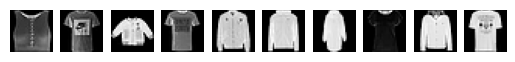

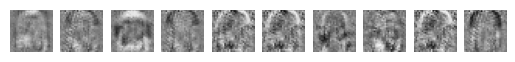

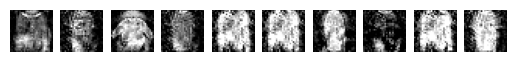

Autoencoder reconstruction error (infinity to 0): 5.989
Counterfactual prediction gain (0 to 1): 0.500
Sparsity (L1, infinity to 0): 0.181


  7%|▋         | 700/10000 [23:53<5:09:42,  2.00s/it]

63/63 [==============================] - 0s 4ms/step
Training iteration 700 at 2025-05-30 17:08:27.228774


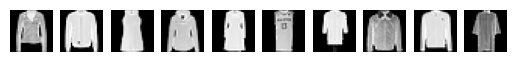

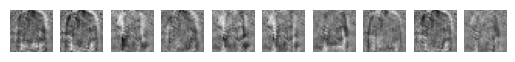

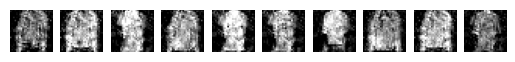

Autoencoder reconstruction error (infinity to 0): 5.662
Counterfactual prediction gain (0 to 1): 0.498
Sparsity (L1, infinity to 0): 0.182


  8%|▊         | 800/10000 [27:32<5:36:34,  2.20s/it]

63/63 [==============================] - 0s 6ms/step
Training iteration 800 at 2025-05-30 17:12:05.912816


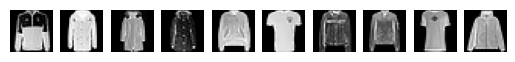

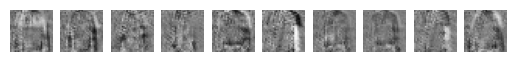

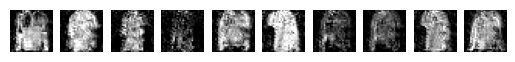

Autoencoder reconstruction error (infinity to 0): 5.301
Counterfactual prediction gain (0 to 1): 0.493
Sparsity (L1, infinity to 0): 0.173


  9%|▉         | 900/10000 [31:22<5:49:15,  2.30s/it]

63/63 [==============================] - 0s 6ms/step
Training iteration 900 at 2025-05-30 17:15:56.453553


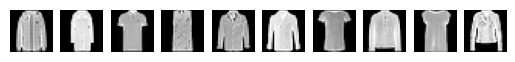

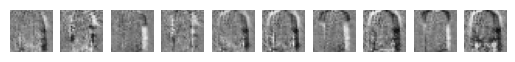

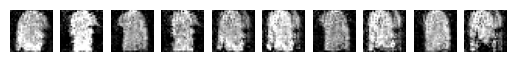

Autoencoder reconstruction error (infinity to 0): 5.075
Counterfactual prediction gain (0 to 1): 0.494
Sparsity (L1, infinity to 0): 0.179


 10%|█         | 1000/10000 [35:06<5:22:05,  2.15s/it]

63/63 [==============================] - 0s 4ms/step
Training iteration 1000 at 2025-05-30 17:19:40.024831


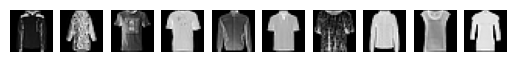

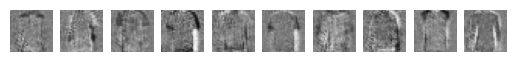

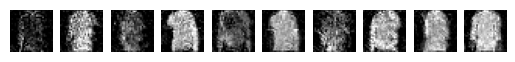

Autoencoder reconstruction error (infinity to 0): 4.974
Counterfactual prediction gain (0 to 1): 0.492
Sparsity (L1, infinity to 0): 0.183


 11%|█         | 1100/10000 [38:52<5:40:48,  2.30s/it]

63/63 [==============================] - 0s 4ms/step
Training iteration 1100 at 2025-05-30 17:23:25.525696


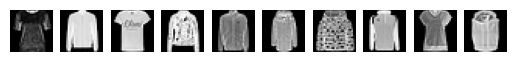

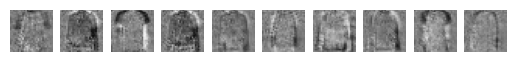

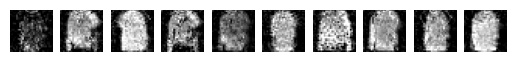

Autoencoder reconstruction error (infinity to 0): 4.625
Counterfactual prediction gain (0 to 1): 0.484
Sparsity (L1, infinity to 0): 0.168


 12%|█▏        | 1200/10000 [43:17<7:19:53,  3.00s/it]

63/63 [==============================] - 0s 4ms/step
Training iteration 1200 at 2025-05-30 17:27:50.821159


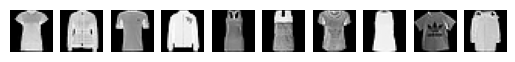

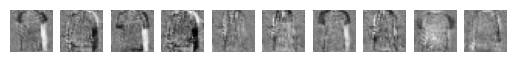

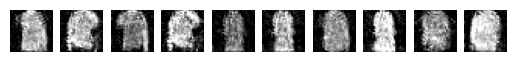

Autoencoder reconstruction error (infinity to 0): 4.873
Counterfactual prediction gain (0 to 1): 0.490
Sparsity (L1, infinity to 0): 0.186


 13%|█▎        | 1300/10000 [48:22<7:44:28,  3.20s/it] 

63/63 [==============================] - 0s 7ms/step
Training iteration 1300 at 2025-05-30 17:32:56.198048


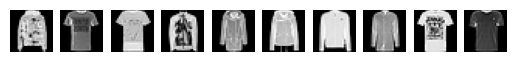

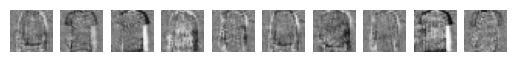

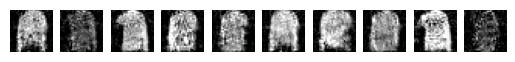

Autoencoder reconstruction error (infinity to 0): 4.696
Counterfactual prediction gain (0 to 1): 0.492
Sparsity (L1, infinity to 0): 0.183


 14%|█▍        | 1400/10000 [54:08<8:48:01,  3.68s/it] 

63/63 [==============================] - 0s 7ms/step
Training iteration 1400 at 2025-05-30 17:38:42.020942


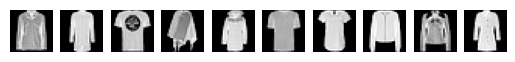

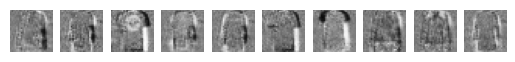

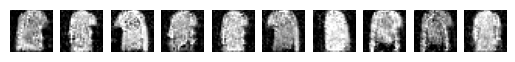

Autoencoder reconstruction error (infinity to 0): 4.619
Counterfactual prediction gain (0 to 1): 0.489
Sparsity (L1, infinity to 0): 0.180


 15%|█▌        | 1500/10000 [1:00:26<9:00:14,  3.81s/it]

63/63 [==============================] - 0s 8ms/step
Training iteration 1500 at 2025-05-30 17:45:00.729356


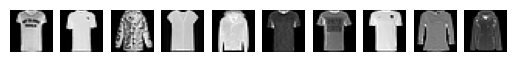

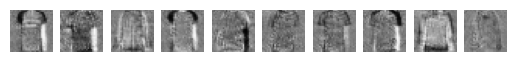

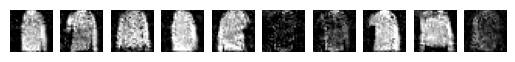

Autoencoder reconstruction error (infinity to 0): 4.480
Counterfactual prediction gain (0 to 1): 0.489
Sparsity (L1, infinity to 0): 0.183


 16%|█▌        | 1600/10000 [1:07:05<10:02:19,  4.30s/it]

63/63 [==============================] - 0s 8ms/step
Training iteration 1600 at 2025-05-30 17:51:39.649144


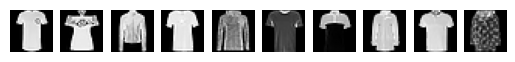

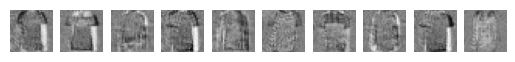

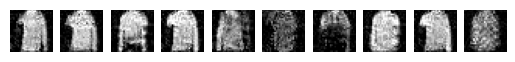

Autoencoder reconstruction error (infinity to 0): 4.414
Counterfactual prediction gain (0 to 1): 0.483
Sparsity (L1, infinity to 0): 0.176


 17%|█▋        | 1700/10000 [1:14:25<10:16:47,  4.46s/it]

63/63 [==============================] - 1s 9ms/step
Training iteration 1700 at 2025-05-30 17:59:00.096656


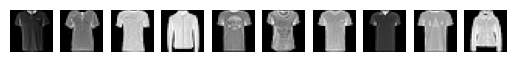

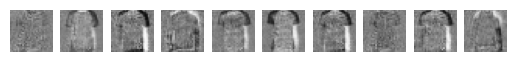

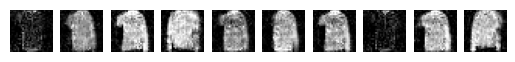

Autoencoder reconstruction error (infinity to 0): 4.293
Counterfactual prediction gain (0 to 1): 0.484
Sparsity (L1, infinity to 0): 0.173


 18%|█▊        | 1800/10000 [1:22:10<10:40:06,  4.68s/it]

63/63 [==============================] - 1s 9ms/step
Training iteration 1800 at 2025-05-30 18:06:44.893969


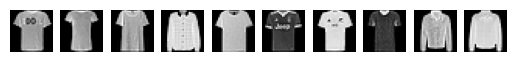

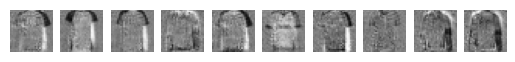

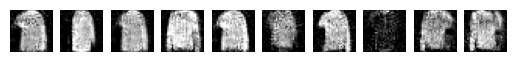

Autoencoder reconstruction error (infinity to 0): 4.244
Counterfactual prediction gain (0 to 1): 0.483
Sparsity (L1, infinity to 0): 0.171


 19%|█▉        | 1900/10000 [1:29:44<9:33:27,  4.25s/it] 

63/63 [==============================] - 0s 6ms/step
Training iteration 1900 at 2025-05-30 18:14:19.028512


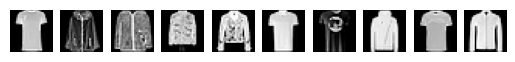

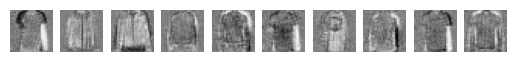

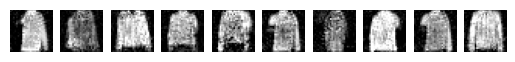

Autoencoder reconstruction error (infinity to 0): 4.333
Counterfactual prediction gain (0 to 1): 0.485
Sparsity (L1, infinity to 0): 0.179


 20%|██        | 2000/10000 [1:37:46<11:30:37,  5.18s/it]

63/63 [==============================] - 1s 9ms/step
Training iteration 2000 at 2025-05-30 18:22:21.835853


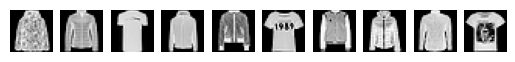

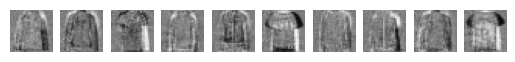

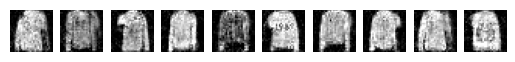

Autoencoder reconstruction error (infinity to 0): 4.141
Counterfactual prediction gain (0 to 1): 0.478
Sparsity (L1, infinity to 0): 0.166


 21%|██        | 2100/10000 [1:46:28<12:22:51,  5.64s/it]

63/63 [==============================] - 1s 10ms/step
Training iteration 2100 at 2025-05-30 18:31:04.155573


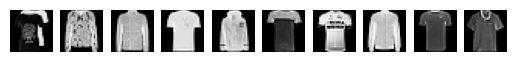

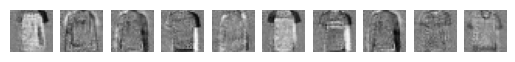

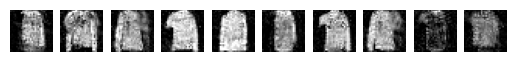

Autoencoder reconstruction error (infinity to 0): 4.067
Counterfactual prediction gain (0 to 1): 0.479
Sparsity (L1, infinity to 0): 0.158


 22%|██▏       | 2200/10000 [1:55:37<13:18:18,  6.14s/it]

63/63 [==============================] - 0s 7ms/step
Training iteration 2200 at 2025-05-30 18:40:12.797237


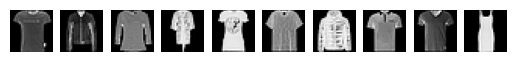

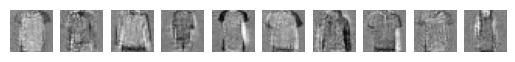

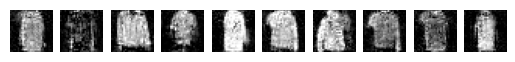

Autoencoder reconstruction error (infinity to 0): 4.168
Counterfactual prediction gain (0 to 1): 0.483
Sparsity (L1, infinity to 0): 0.162


 23%|██▎       | 2300/10000 [2:04:35<12:20:11,  5.77s/it]

63/63 [==============================] - 1s 10ms/step
Training iteration 2300 at 2025-05-30 18:49:11.381556


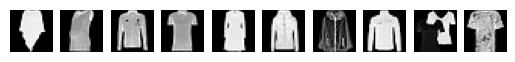

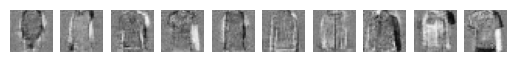

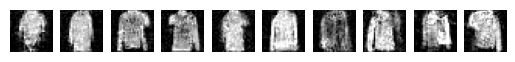

Autoencoder reconstruction error (infinity to 0): 4.100
Counterfactual prediction gain (0 to 1): 0.476
Sparsity (L1, infinity to 0): 0.164


 24%|██▍       | 2400/10000 [2:13:06<11:37:59,  5.51s/it]

63/63 [==============================] - 1s 9ms/step
Training iteration 2400 at 2025-05-30 18:57:42.227687


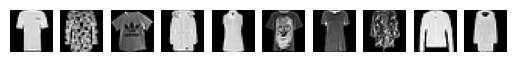

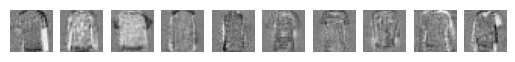

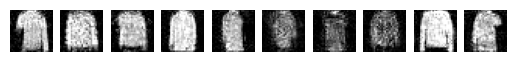

Autoencoder reconstruction error (infinity to 0): 3.987
Counterfactual prediction gain (0 to 1): 0.474
Sparsity (L1, infinity to 0): 0.156


 25%|██▌       | 2500/10000 [2:22:19<10:02:20,  4.82s/it]

63/63 [==============================] - 0s 6ms/step
Training iteration 2500 at 2025-05-30 19:06:53.775152


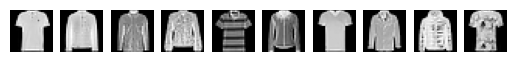

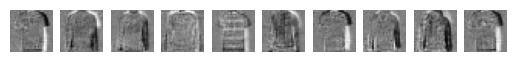

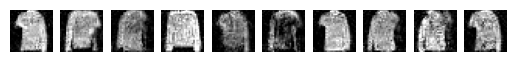

Autoencoder reconstruction error (infinity to 0): 3.948
Counterfactual prediction gain (0 to 1): 0.473
Sparsity (L1, infinity to 0): 0.155


 26%|██▌       | 2600/10000 [2:31:56<11:27:44,  5.58s/it]

63/63 [==============================] - 1s 10ms/step
Training iteration 2600 at 2025-05-30 19:16:32.183740


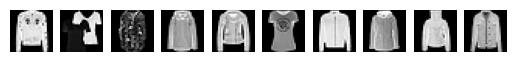

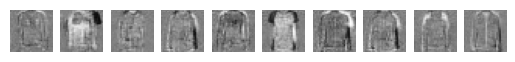

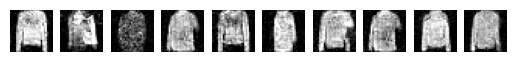

Autoencoder reconstruction error (infinity to 0): 3.978
Counterfactual prediction gain (0 to 1): 0.474
Sparsity (L1, infinity to 0): 0.159


 27%|██▋       | 2700/10000 [2:40:58<11:04:43,  5.46s/it]

63/63 [==============================] - 1s 8ms/step
Training iteration 2700 at 2025-05-30 19:25:33.750082


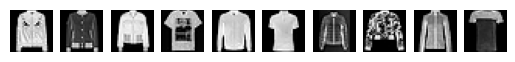

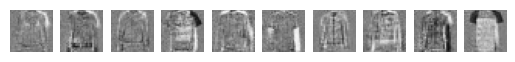

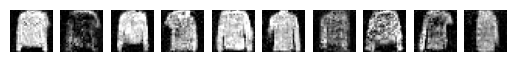

Autoencoder reconstruction error (infinity to 0): 3.951
Counterfactual prediction gain (0 to 1): 0.475
Sparsity (L1, infinity to 0): 0.161


 28%|██▊       | 2800/10000 [2:50:14<11:20:16,  5.67s/it]

63/63 [==============================] - 0s 7ms/step
Training iteration 2800 at 2025-05-30 19:34:49.888487


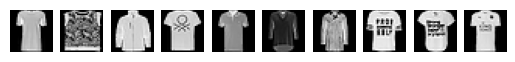

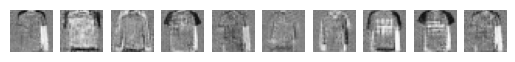

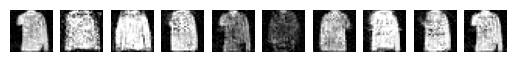

Autoencoder reconstruction error (infinity to 0): 3.937
Counterfactual prediction gain (0 to 1): 0.477
Sparsity (L1, infinity to 0): 0.160


 29%|██▉       | 2900/10000 [2:59:52<11:31:25,  5.84s/it]

63/63 [==============================] - 0s 8ms/step
Training iteration 2900 at 2025-05-30 19:44:27.470524


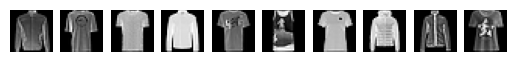

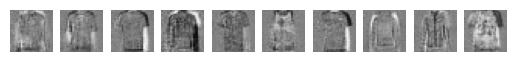

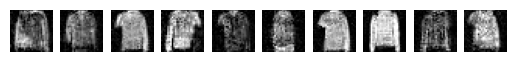

Autoencoder reconstruction error (infinity to 0): 3.840
Counterfactual prediction gain (0 to 1): 0.473
Sparsity (L1, infinity to 0): 0.155


 29%|██▉       | 2910/10000 [3:00:57<7:20:54,  3.73s/it] 


KeyboardInterrupt: 

In [14]:
method_name = "countergan"
countergan = train_countergan(2, 3, 10000, baseline_classifier, discriminator, generator, batches)

In [19]:
models_save_dir = r'D:\PycharmProjects\CF-Robustness-Benchmark\cf_output\fmnist\countergan_binary\checkpoints'

In [20]:
generator.save(osp.join(models_save_dir, 'generator_iter_2900.keras'))
discriminator.save(osp.join(models_save_dir, 'discriminator_iter_2900.keras'))

# Evaluation of CounterGAN

Load perts of CounteRGAN

In [30]:
generator = load_model(r'D:\PycharmProjects\RecourseRobustnessBenchmark\carla_visual\recourse_methods\countergan\weights\binary_generator_targetc_8_5000it.keras')
discriminator = load_model(r'D:\PycharmProjects\RecourseRobustnessBenchmark\carla_visual\recourse_methods\countergan\weights\binary_discriminator_targetc_8_5000it.keras')

In [13]:
class_ind = np.where(tf.argmax(y_test, axis=1)==class_encodings[INIT_CLASS])[0]
factuals = X_test[class_ind]
labels =  y_test[class_ind]

# factuals = tf.concat(factuals, axis=0)
# labels = tf.concat(labels, axis=0)

shuffled_indices = tf.random.shuffle(tf.range(labels.shape[0]))  # Generate shuffled indices
labels = tf.gather(labels, shuffled_indices)  # Reorder labels

# Shuffle images if needed to align with new label order
factuals = tf.gather(factuals, shuffled_indices)
print('Total number of factual instances: ', factuals.shape[0])

Total number of factual instances:  2000


In [14]:
predictions = tf.argmax(baseline_classifier.predict(factuals, verbose=0), axis=1)
_, valid_indices = np.where([predictions == tf.argmax(labels, axis=1)])
factuals = tf.gather(factuals, valid_indices)
labels = tf.gather(labels, valid_indices) 

In [15]:
cfes = generator.predict(factuals, verbose=0)
cfes_pred = tf.argmax(baseline_classifier.predict(cfes, verbose=0), axis=1)
validity = len(np.where(cfes_pred == tf.ones_like(cfes_pred)*class_encodings[DESIRED_CLASS])[0]) / len(cfes)
print(f'Validity of the generated CFEs: {validity:.2%}')

Validity of the generated CFEs: 0.00%


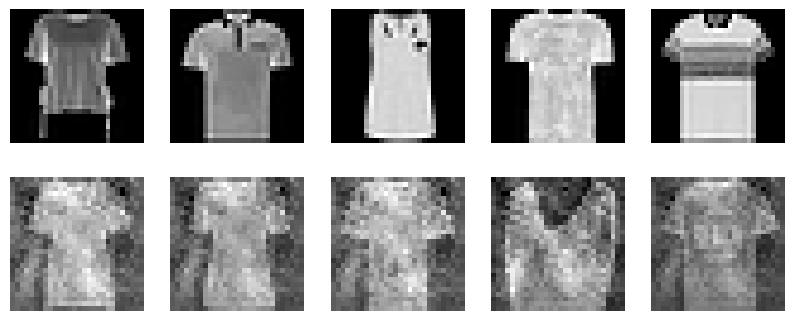

In [16]:
n_rows = 2
n_cols = 5

k = 0

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 4))
for i in range(n_rows):
    for j in range(n_cols):
        if i == 0:
            axs[i, j].imshow(factuals[k].numpy(), cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_ylabel('CFE /wo noise')
        else:
            axs[i, j].imshow(cfes[k], cmap='gray')
            # axs[i, j].set_title('epsilon='+str(noise)) 
            axs[i, j].axis('off')
            axs[i, j].set_ylabel('CFE /w noise')
        k += 1
plt.show()

## Robustness Evaluation

### Local Instability

In [35]:
from src.evaluation.local_instability import perturb_sample
from src.evaluation.local_instability import calculate_sparsity, calculate_ssim
from src.utils.visualization import plot_boxplot

In [36]:
noise_levels = [0.001, 0.0025, 0.005, 0.0075, 0.01]

In [37]:
factuals_pert = {}
pert_indices = {}

for noise_level in noise_levels:
    pert_sample = perturb_sample(factuals, n_samples=1, noise_magnitude=noise_level) #.permute(0, 2, 3, 1).numpy()

    # Check whether perturbed instances lead to the same class prediction
    predictions = tf.argmax(baseline_classifier.predict(pert_sample, verbose=0), axis=1)
   
    targets = tf.argmax(labels, axis=1)
    indices = np.where(predictions == targets)[0]
    pert_indices[noise_level] = indices

    factuals_pert[noise_level] = tf.gather(pert_sample, indices, axis=0)
    print(f'Number of valid perturbed factuals for the added noise level {noise_level}: ', factuals_pert[noise_level].shape[0])

Number of valid perturbed factuals for the added noise level 0.001:  1135
Number of valid perturbed factuals for the added noise level 0.0025:  1134
Number of valid perturbed factuals for the added noise level 0.005:  1133
Number of valid perturbed factuals for the added noise level 0.0075:  1132
Number of valid perturbed factuals for the added noise level 0.01:  1129


In [38]:
from functools import reduce

n = 100
final_indices = reduce(np.intersect1d, (valid_indices, *list(pert_indices.values())))[:n]

In [41]:
factuals = tf.gather(factuals, final_indices) 
labels = tf.gather(labels, final_indices)

In [42]:
cfes = tf.gather(cfes, final_indices).numpy()
factuals_pert = {k : tf.gather(v, final_indices) for k, v in factuals_pert.items()}

In [43]:
cfes_pert =  {k: generator.predict(v, verbose=0) for k, v in factuals_pert.items()} 

In [ ]:
validity_list = []
for noise_level, cf_prediction in zip(noise_levels, cf_pert_predictions):
    validity = calculate_validity(cf_prediction, cf_targets_tensor)
    print(f'Validity under the noise level {noise_level}:', validity)
    validity_list.append(validity)

output_dir = r'D:\PycharmProjects\RecourseRobustnessBenchmark\experiments\binary_classification\output'
with open(osp.join(output_dir, f'countergan_bin_validity_pert_n{n}.pkl'), 'wb') as f:
    pickle.dump(validity_list, f)

In [59]:
cfes_pert_predictions = {}
validity_list = []

for noise_level in noise_levels:
    predictions = tf.argmax(baseline_classifier.predict(cfes_pert[noise_level], verbose=0), axis=1)
    cfes_pert_predictions[noise_level] = predictions

    validity = len(np.where(predictions == tf.ones_like(predictions)*class_encodings[DESIRED_CLASS])[0]) / len(cfes)
    print(f'Validity of the generated CFEs for correctly classified instances: {validity:.2%}')
    validity_list.append(validity)

output_dir = r'D:\PycharmProjects\Counterfactual-Robustness-Benchmark\output\countergan_binary'
with open(osp.join(output_dir, 'countergan_bin_validity.pkl'), 'wb') as f:
    pickle.dump(validity_list, f)

Validity of the generated CFEs for correctly classified instances: 15.00%
Validity of the generated CFEs for correctly classified instances: 14.00%
Validity of the generated CFEs for correctly classified instances: 11.00%
Validity of the generated CFEs for correctly classified instances: 11.00%
Validity of the generated CFEs for correctly classified instances: 9.00%


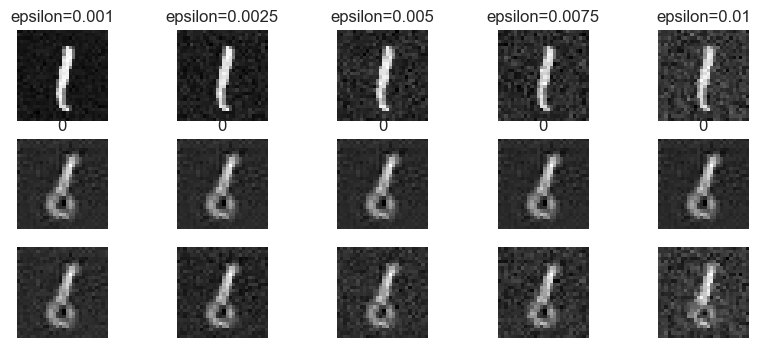

In [44]:
n_rows = 3
n_cols = 5

ind = 20

# factuals_pert = {}    
cfes_pert_predictions = {}

for noise_level in noise_levels:
    # factuals_pert[noise_level] = perturb_sample(factuals, n_samples=1, noise_magnitude=noise_level)
    cfes_pert_predictions[noise_level] = tf.argmax(baseline_classifier.predict(cfes_pert[noise_level], verbose=0), axis=1)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 4))
for i in range(n_rows):
    for j in range(n_cols):
        noise = noise_levels[j]
        if i == 0: 
            pert_image = factuals_pert[noise][ind]  #perturb_sample(factuals_tensor[ind].unsqueeze(0), noise_magnitude=noise).squeeze().squeeze()
            axs[i, j].imshow(pert_image, cmap='gray')
            axs[i, j].set_title('epsilon='+str(noise)) 
            axs[i, j].axis('off')
        elif i == 1:
            axs[i, j].imshow(cfes[ind].squeeze(), cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_title(str(cfes_pert_predictions[noise_level][ind].numpy().item())) 
            axs[i, j].set_ylabel('CFE /wo noise')
        else:
            axs[i, j].imshow(cfes_pert[noise][ind], cmap='gray')
            # axs[i, j].set_title('epsilon='+str(noise)) 
            axs[i, j].axis('off')
            axs[i, j].set_ylabel('CFE /w noise')
plt.show()

In [45]:
# Calculating L1 distance between the explanations of original and perturbed instances
l1_list = []
ssim_list = []


for i, noise_level in tqdm(enumerate(cfes_pert.keys())):
    l1_temp = []
    ssim_temp = []

    cfs_pert = cfes_pert[noise_level]

    for i in tqdm(range(cfes_pert[noise_level].shape[0])): 

        l1_distance = calculate_sparsity(cfes[i].flatten(), cfes_pert[noise_level][i].flatten()).item()
        # sum(abs(cfes[i].flatten() - cfes_pert[noise_level][i].flatten())) #
        l1_temp.append(l1_distance)

        ssim = calculate_ssim(torch.Tensor(cfes[i]).permute(2, 0, 1).unsqueeze(0), 
                              torch.Tensor(cfes_pert[noise_level][i]).permute(2, 0, 1).unsqueeze(0)).item()
        ssim_temp.append(ssim)

    print(f'Average Instability (L1) for the set of counterfactuals of size : {np.mean(l1_temp)}')    
    l1_list.append(l1_temp)
    
    print(f'Average SSIM for the set of counterfactuals of size : {np.mean(ssim_temp)}')    
    ssim_list.append(ssim_temp)

100%|██████████| 100/100 [00:00<00:00, 294.62it/s]
1it [00:00,  2.87it/s]

Average Instability (L1) for the set of counterfactuals of size : 20.15952703475952
Average SSIM for the set of counterfactuals of size : 0.9100335168838501


100%|██████████| 100/100 [00:00<00:00, 387.79it/s]
2it [00:00,  3.36it/s]

Average Instability (L1) for the set of counterfactuals of size : 32.76341459274292
Average SSIM for the set of counterfactuals of size : 0.8130669122934342


100%|██████████| 100/100 [00:00<00:00, 364.12it/s]
3it [00:00,  3.45it/s]

Average Instability (L1) for the set of counterfactuals of size : 48.02870323181153
Average SSIM for the set of counterfactuals of size : 0.7001548224687576


100%|██████████| 100/100 [00:00<00:00, 344.58it/s]
4it [00:01,  3.43it/s]

Average Instability (L1) for the set of counterfactuals of size : 61.15798969268799
Average SSIM for the set of counterfactuals of size : 0.6127428635954857


100%|██████████| 100/100 [00:00<00:00, 294.82it/s]
5it [00:01,  3.26it/s]

Average Instability (L1) for the set of counterfactuals of size : 73.39838424682617
Average SSIM for the set of counterfactuals of size : 0.5417368584871292


In [57]:
output_dir = r'D:\PycharmProjects\Counterfactual-Robustness-Benchmark\output\countergan_binary'
with open(osp.join(output_dir, 'countergan_li_l1.pkl'), 'wb') as f:
    pickle.dump(l1_list, f)

with open(osp.join(output_dir, 'countergan_ssim.pkl'), 'wb') as f:
    pickle.dump(ssim_list, f)

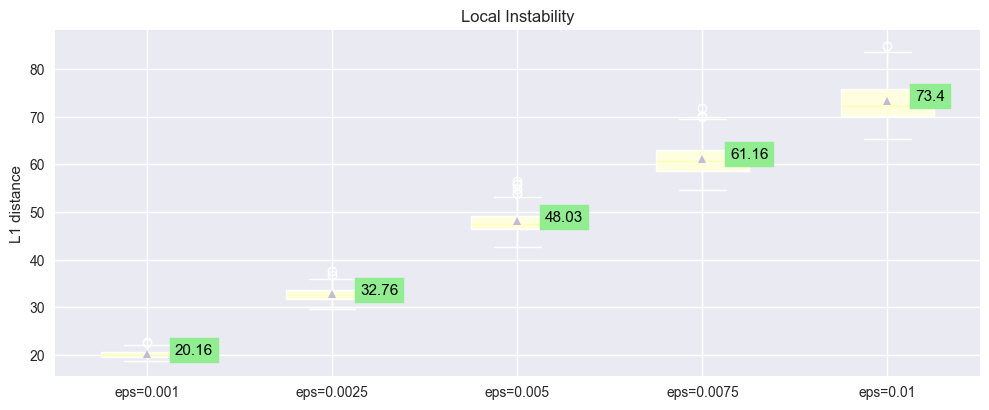

In [46]:
plt.style.use("seaborn-v0_8-notebook")
plt.rcParams['figure.figsize'] = [10, 4]

plot_boxplot(data=l1_list, mean_values=[np.round(np.mean(inst),2) for inst in l1_list],
             tick_labels=[f'eps={noise_level}' for noise_level in noise_levels],
             y_label='L1 distance', colors=['lightyellow'], title='Local Instability')

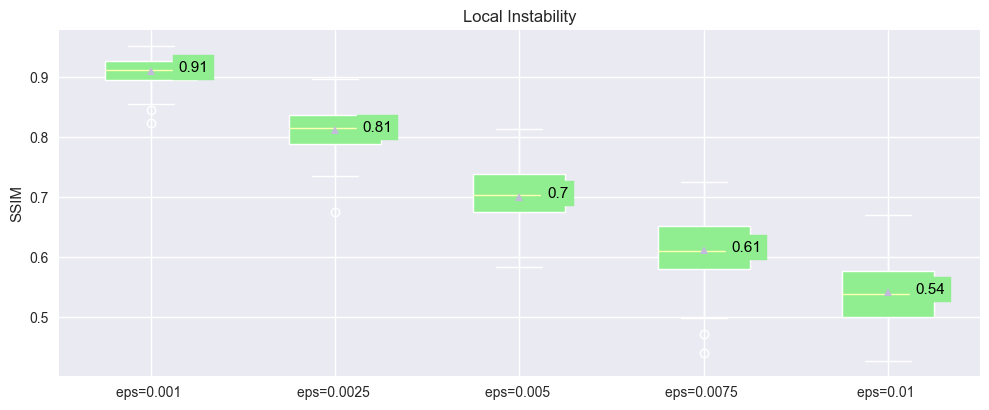

In [47]:
plot_boxplot(data=ssim_list, mean_values=[np.round(np.mean(inst),2) for inst in ssim_list],
             tick_labels=[f'eps={noise_level} ' for noise_level in noise_levels],
             y_label='SSIM', colors=['lightgreen'], title='Local Instability')

## Local Lipschitz Continuity

In [59]:
original_points = factuals
original_cfes = cfes
print("Are the lengths of initial points (factuals) and CFEs generated for them equal :", original_cfes.shape[0] == original_points.shape[0])


Are the lengths of initial points (factuals) and CFEs generated for them equal : True


In [60]:
noise_magnitude = 0.001

lip_estimates = []

for original_point, original_cfe in tqdm(zip(original_points, original_cfes), total=original_points.shape[0]):

    neighbor_points = perturb_sample(tf.expand_dims(original_point, axis=0), n_samples=50, noise_magnitude=noise_magnitude)    
    neighbor_cfes = generator.predict(neighbor_points, verbose=False)

    lip_estimate = 0
    for m, p in zip(neighbor_cfes, neighbor_points):
        num = np.linalg.norm((original_cfe - m).flatten(), ord=2) 
        denom = np.linalg.norm((original_point.numpy() - p).flatten(), ord=2)
        lip = num / denom
        lip_estimate = max(lip, lip_estimate)
 
    lip_estimates.append(lip_estimate)


100%|██████████| 100/100 [01:00<00:00,  1.64it/s]


In [61]:
output_dir = r'D:\PycharmProjects\Counterfactual-Robustness-Benchmark\output\countergan_binary'
with open(osp.join(output_dir, 'countergan_lle.pkl'), 'wb') as f:
    pickle.dump(lip_estimates, f)

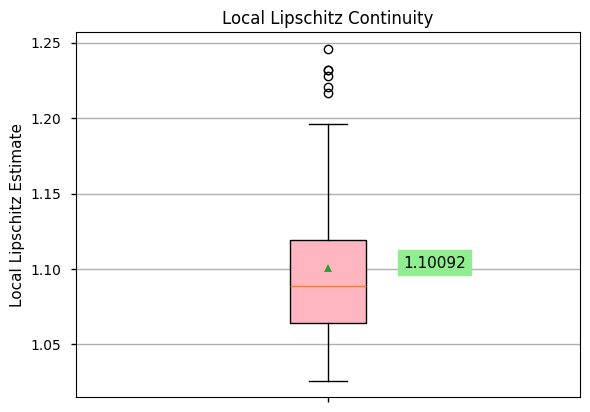

In [62]:
plt.rcParams['figure.figsize'] = [6, 4]
plot_boxplot(data=lip_estimates, mean_values=[np.round(np.mean(lip_estimates), 5)],
             tick_labels=[''],
             y_label='Local Lipschitz Estimate', colors=['lightpink'], title='Local Lipschitz Continuity')

## Invalidation Rate

Weights reinitialization

In [48]:
classifiers_weights_dir = r'D:\PycharmProjects\Counterfactual-Robustness-Benchmark\src\models\weights\tf\binary_mc'

batch_size = 128


classifiers_list = []
for clf_fname in os.listdir(classifiers_weights_dir):
    cnn_perturbed = load_model(osp.join(classifiers_weights_dir, clf_fname), 
                            custom_objects={'CNNtf': CNNtf})
    classifiers_list.append(cnn_perturbed)

    logits = cnn_perturbed.predict(X_test)
    accuracy = (logits.argmax(axis=1) == y_test[:, 0]).numpy().mean()
    print(f"Classifier accuracy test: {accuracy:.3%}")

66/66 [==============================] - 1s 7ms/step
Classifier accuracy test: 99.905%
66/66 [==============================] - 1s 6ms/step
Classifier accuracy test: 99.573%
66/66 [==============================] - 0s 6ms/step
Classifier accuracy test: 99.953%
66/66 [==============================] - 0s 5ms/step
Classifier accuracy test: 99.953%
66/66 [==============================] - 0s 5ms/step
Classifier accuracy test: 99.953%
66/66 [==============================] - 0s 5ms/step
Classifier accuracy test: 99.763%
66/66 [==============================] - 0s 5ms/step
Classifier accuracy test: 100.000%
66/66 [==============================] - 0s 5ms/step
Classifier accuracy test: 99.905%
66/66 [==============================] - 0s 5ms/step
Classifier accuracy test: 99.953%
66/66 [==============================] - 0s 6ms/step
Classifier accuracy test: 99.953%


Evaluate IR only for the valid explanations for the baseline classifier

In [49]:
predictions = tf.argmax(baseline_classifier.predict(cfes, verbose=0), axis=1)
indices = np.where(predictions == tf.ones_like(predictions)*class_encodings[DESIRED_CLASS])[0]
cfes_subsample = tf.gather(cfes, indices)
cfes_subsample.shape

validity = len(np.where(predictions == tf.ones_like(predictions)*class_encodings[DESIRED_CLASS])[0]) / len(cfes)
print(f'Validity of the generated CFEs for correctly classified instances: {validity:.2%}')

Validity of the generated CFEs for correctly classified instances: 15.00%


In [52]:
invalidation_rate_list = []
validity_list = []
total_cfs = cfes.shape[0]

for i, classifier in enumerate(classifiers_list):
    invalidation_rate = 0

    baseline_pred = tf.argmax(baseline_classifier.predict(cfes_subsample, verbose=0), axis=1)
    alternative_pred = tf.argmax(classifier.predict(cfes_subsample, verbose=0), axis=1)

    inv_indices = tf.where(baseline_pred != alternative_pred)
    inv_instances = tf.gather(cfes_subsample, inv_indices) 
    inv_predictions = tf.gather(alternative_pred, inv_indices)
    print('number of invalidated instances', inv_indices.shape[0])
    # fig, ax = plt.subplots(1, 3)
    # for i in range(3):
    #     ax[i].imshow(inv_instances[i][0], cmap='gray')
    #     ax[i].axis('off')
    #     ax[i].set_title(inv_predictions[i].numpy())
    
    invalidation_rate = inv_indices.shape[0] / total_cfs
    invalidation_rate_list.append(invalidation_rate)

    validity = tf.where(alternative_pred == class_encodings[DESIRED_CLASS]).shape[0] / total_cfs

    validity_list.append(validity)

    print(f'Model {i}: IR={invalidation_rate}, validity={validity}\n')

print(f'Average IR among {len(classifiers_list)} models: ', np.mean(invalidation_rate_list), np.std(invalidation_rate_list))
print(f'Average VaR among {len(classifiers_list)} models: ', np.mean(validity_list), np.std(validity_list))


number of invalidated instances 1
Model 0: IR=0.01, validity=0.14

number of invalidated instances 7
Model 1: IR=0.07, validity=0.08

number of invalidated instances 0
Model 2: IR=0.0, validity=0.15

number of invalidated instances 3
Model 3: IR=0.03, validity=0.12

number of invalidated instances 0
Model 4: IR=0.0, validity=0.15

number of invalidated instances 0
Model 5: IR=0.0, validity=0.15

number of invalidated instances 0
Model 6: IR=0.0, validity=0.15

number of invalidated instances 0
Model 7: IR=0.0, validity=0.15

number of invalidated instances 2
Model 8: IR=0.02, validity=0.13

number of invalidated instances 2
Model 9: IR=0.02, validity=0.13

Average IR among 10 models:  0.015 0.021095023109728987
Average VaR among 10 models:  0.135 0.02109502310972898


## Stability 

In [54]:
k = 1000
sigma = 0.001

average_stability_list = []


for i, classifier in enumerate(classifiers_list):
    stability_list = []
    stability = 0

    original_logits = classifier.predict(cfes_subsample, verbose=0)
    # To calculate stability of only valid CFE, they need to be identified
    valid_cfs_ind = tf.where(original_logits.argmax(axis=1) == class_encodings[DESIRED_CLASS])[:, 0]
    original_logits_subsample = tf.gather(original_logits, valid_cfs_ind)

    original_probabilities = tf.nn.softmax(original_logits_subsample, axis=-1)[:, class_encodings[DESIRED_CLASS]]

    valid_cfs_subsample = tf.gather(cfes_subsample, valid_cfs_ind)
    cf_sample_pert = perturb_sample(valid_cfs_subsample, n_samples=k, noise_magnitude=sigma)

    logits = classifier.predict(cf_sample_pert, verbose=0)
    probabilities = tf.nn.softmax(logits, axis=-1)[:, class_encodings[DESIRED_CLASS]]

    for j in range(original_probabilities.shape[0]):
        original_probabilities_i = tf.expand_dims(original_probabilities[j], axis=-1)
        # print(original_probabilities_i.shape)
        model_variance = abs(original_probabilities_i - probabilities[j*k : j*k+k])
        # print(probabilities[i*k:i*k+k].shape)
        # print(model_variance.shape)
        stability = (probabilities[j*k:j*k+k] - model_variance).numpy().mean()
        stability_list.append(stability)

    avg_i_stability = np.mean(stability_list)
    print(f'Average Stability of the model {i}: {round(avg_i_stability.item(), 3)} +- {round(np.std(stability_list).item(), 2)}')
    average_stability_list.append(avg_i_stability)


Average Stability of the model 0: 0.607 +- 0.04
Average Stability of the model 1: 0.589 +- 0.04
Average Stability of the model 2: 0.774 +- 0.08
Average Stability of the model 3: 0.799 +- 0.04
Average Stability of the model 4: 0.666 +- 0.06
Average Stability of the model 5: 0.891 +- 0.1
Average Stability of the model 6: 0.836 +- 0.08
Average Stability of the model 7: 0.866 +- 0.07
Average Stability of the model 8: 0.618 +- 0.04
Average Stability of the model 9: 0.856 +- 0.05


In [55]:
print(f"Average stability across {len(average_stability_list)} equally performative models: \
{round(np.mean(average_stability_list).item(), 3)} +- {round(np.std(average_stability_list).item(), 3)}")

Average stability across 10 equally performative models: 0.75 +- 0.112
